In [31]:
import os
import numpy as np
import pandas as pd
import math

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LSTM, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
dataset = pd.read_csv("processed_EURUSD.csv")
x = dataset.drop(columns="Date").values

In [4]:
params = {'batch_size': 100, 'dense_layers': {'dense2_nodes': 60, 'layers': 'two'}, 'epochs': 100,
          'lstm1_dropouts': 0.2050246384619, 'lstm1_nodes': 200, 'lstm_layers': {'layers': 'two', 'lstm2_dropouts': 0.202794539131167, 'lstm2_nodes': 90}, 'time_steps': 45}
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

In [8]:
def build_timeseries(mat, y_col_index,TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [9]:
x_t, y_t = build_timeseries(x, 0,TIME_STEPS)
x_train = x_t[:int(0.75*len(x_t))]
x_val = x_t[int(0.75*len(x_t)):]

y_train = y_t[:int(0.75*len(y_t))]
y_val = y_t[int(0.75*len(y_t)):]

x_train = trim_dataset(x_train, BATCH_SIZE)
y_train = trim_dataset(y_train, BATCH_SIZE)

x_val = trim_dataset(x_val, BATCH_SIZE)
y_val = trim_dataset(y_val, BATCH_SIZE)

length of time-series i/o (4217, 45, 23) (4217,)


In [27]:
def create_model(params):
    print("Trying params:",params)    
    lstm_model = Sequential()
    lstm_model.add(LSTM(params["lstm1_nodes"], batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_train.shape[2]), dropout=params["lstm1_dropouts"],
                        stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))  
    
    if params["lstm_layers"]["layers"] == "two":
        lstm_model.add(LSTM(params["lstm_layers"]["lstm2_nodes"], dropout=params["lstm_layers"]["lstm2_dropouts"]))
    else:
        lstm_model.add(tf.keras.layers.Flatten())

    if params["dense_layers"]["layers"] == 'two':
        lstm_model.add(Dense(params["dense_layers"]["dense2_nodes"], activation='relu'))
    
    lstm_model.add(Dense(1, activation='tanh'))
    
    lstm_model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam())
    return lstm_model

lstm_model = create_model(params)
csv_logger = tf.keras.callbacks.CSVLogger('lstm_train.log', append=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-5,
        patience=10,
        verbose=1,
        restore_best_weights=True),
        tf.keras.callbacks.CSVLogger('lstm_train.log', append=True)
]
history = lstm_model.fit(x_train, y_train, epochs=params['epochs'], verbose=2,
                    batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(x_val,y_val),
                    callbacks=callbacks)

Trying params: {'batch_size': 100, 'dense_layers': {'dense2_nodes': 60, 'layers': 'two'}, 'epochs': 100, 'lstm1_dropouts': 0.2050246384619, 'lstm1_nodes': 200, 'lstm_layers': {'layers': 'two', 'lstm2_dropouts': 0.202794539131167, 'lstm2_nodes': 90}, 'time_steps': 45}
Train on 3100 samples, validate on 1000 samples
Epoch 1/100
3100/3100 - 4s - loss: 0.0109 - val_loss: 0.0091
Epoch 2/100
3100/3100 - 4s - loss: 0.0026 - val_loss: 0.0093
Epoch 3/100
3100/3100 - 4s - loss: 0.0039 - val_loss: 0.0220
Epoch 4/100
3100/3100 - 4s - loss: 0.0093 - val_loss: 0.0039
Epoch 5/100
3100/3100 - 4s - loss: 0.0028 - val_loss: 0.0266
Epoch 6/100
3100/3100 - 4s - loss: 0.0069 - val_loss: 0.0413
Epoch 7/100
3100/3100 - 4s - loss: 0.0076 - val_loss: 0.0024
Epoch 8/100
3100/3100 - 4s - loss: 0.0042 - val_loss: 0.0282
Epoch 9/100
3100/3100 - 4s - loss: 0.0100 - val_loss: 0.0047
Epoch 10/100
3100/3100 - 4s - loss: 0.0042 - val_loss: 0.0302
Epoch 11/100
3100/3100 - 4s - loss: 0.0098 - val_loss: 0.0373
Epoch 12/10

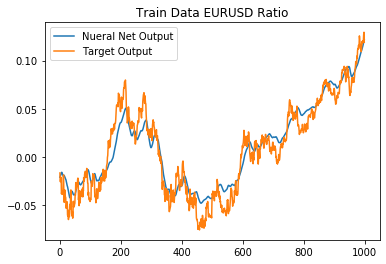

In [28]:
test_predictions = lstm_model.predict(x_train[:1000])
plt.plot(test_predictions,label="Nueral Net Output")
plt.plot(y_train[:1000],label="Target Output")
plt.title("Train Data EURUSD Ratio")
plt.legend()
plt.show()

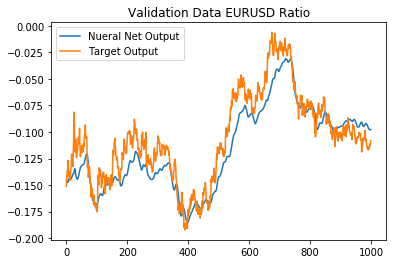

In [29]:
test_predictions = lstm_model.predict(x_val)
plt.plot(test_predictions,label="Nueral Net Output")
plt.plot(y_val,label="Target Output")
plt.title("Validation Data EURUSD Ratio")
plt.legend()
plt.show()

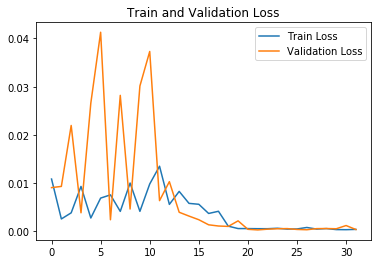

In [30]:
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'],label="Validation Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.show()